In [1]:
library(pwr)
library(purrr)

inv.logit <- function(x) {
    1 / (1 + exp(-x))
}

data_causal_inf <- function(n, tau = 1, b = 2, base = 100) {
    ## DGP
    age <- rnbinom(n, 10, 0.3)
    ps <- inv.logit(0.2*(age- mean(age)))
    Y0s <- round(base + b * age + rnorm(n, 0, 3))
    Y1s <- round(Y0s + tau)
    Z <- map_dbl(ps, ~ sample(c(0,1), 1, F, c(1-., .)))
    Y <- Z * Y1s + (1-Z) * Y0s
    return(list(age = age, Y = Y, Z = Z, ps = ps))
}

data_causal_inf_rand_exp <- function(n, tau = 1, b = 2, base = 100) {
    ## DGP
    age <- rnbinom(n, 10, 0.3)
    ps <- inv.logit(0.2*(age- mean(age)))
    Y0s <- round(base + b * age + rnorm(n, 0, 3))
    Y1s <- round(Y0s + tau)
    Z <- rbinom(n, 1, 0.5)
    Y <- Z * Y1s + (1-Z) * Y0s
    return(list(age = age, Y = Y, Z = Z, ps = ps))
}

set.seed(7)
n <- 500

causal_int_obs <- data_causal_inf(n, tau = 0.9123, b = - 1.0314)

Age <- causal_int_obs$age; StreamingMinutes <- causal_int_obs$Y; AccountType <- ifelse(causal_int_obs$Z, "Premium", "Free")
musicfi <- data.frame(Age, AccountType, StreamingMinutes)

causal_int_obsrand <- data_causal_inf_rand_exp(n=500, tau = 0.9123, b = - 0.5314)

Age <- causal_int_obsrand$age; StreamingMinutes <- causal_int_obsrand$Y; AccountType <- ifelse(causal_int_obsrand$Z, "Premium", "Free")
musicfiExp <- data.frame(Age, AccountType, StreamingMinutes)

Warning message:
"package 'pwr' was built under R version 3.6.3"

# Randomized Experiments

Randomized experiments remove the selection problem and ensure that there are no confounding variables (observed or unobserved). They do this by removing the individual’s opportunity to select whether or not they receive the treatment. In the Musicfi example, suppose we ran an experiment with 500 participants where we randomly upgraded some free accounts to premium accounts. Now, we no longer have to adjust for age as (on average) there will be no age difference between the treated and control subjects. Suppose the data from our experiment is stored in a data frame called `musicfiExp`:

In [2]:
head(musicfiExp)

Age,AccountType,StreamingMinutes
20,Premium,92
28,Free,88
20,Premium,89
24,Premium,86
22,Premium,91
15,Premium,93


Unlike the observational data from the previous section, there is now no significant difference in age between the treatment and control groups:

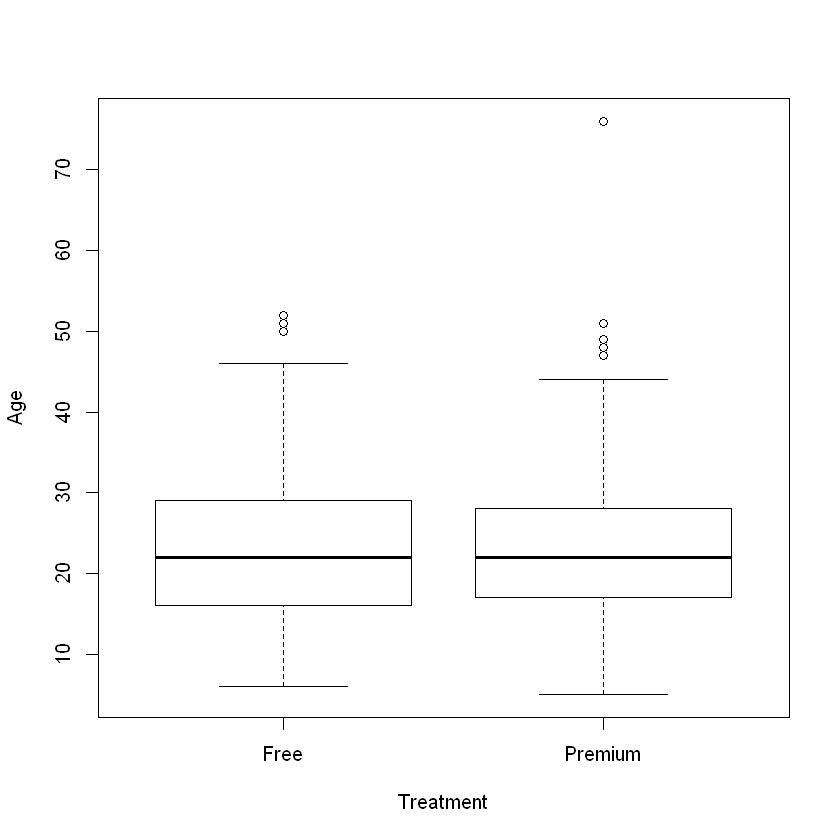

In [3]:
boxplot(musicfiExp$Age ~ musicfiExp$AccountType, ylab = "Age", xlab = "Treatment")

Age is not a confounding variable as it is independent of the treatment assignment. We can now directly attribute any differences in the outcome due to the intervention. This allows us to conclude that giving people a premium account increases streaming minutes.


	Welch Two Sample t-test

data:  musicfiExp$StreamingMinutes by musicfiExp$AccountType
t = -2.5057, df = 497.95, p-value = 0.01254
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.2728058 -0.2750465
sample estimates:
   mean in group Free mean in group Premium 
             87.55285              88.82677 


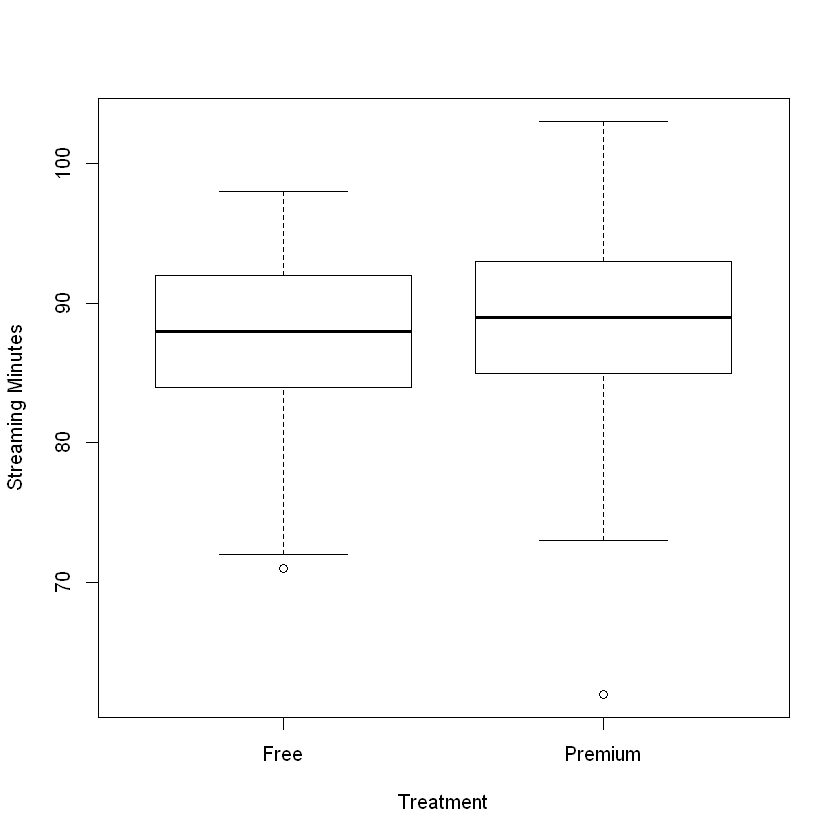

In [4]:
boxplot(StreamingMinutes ~ AccountType, ylab = "Streaming Minutes", xlab = "Treatment")
t.test(musicfiExp$StreamingMinutes ~ musicfiExp$AccountType)

The difference may be relatively small, but the low p-value indicates that the difference is statistically significant. 


## Designing an Experiment

Now that we know why experimentation is necessary, let’s review the steps that businesses use to design their experiments.

#### 1. Generate a Hypothesis

The starting point to any experiment is to generate a hypothesis. For companies these hypotheses take the following form:

> If we [do this] then [this outcome] will increase/decrease by [this much].

+ [do this]: describes the treatment; most of the time, we implicitly assume that the control is the current approach, and hence it is not explicitly mentioned.
+ [this outcome]: describes the outcome we expect the treatment will affect.
+ [this much]: describes our best guess at the likely effect of the treatment on the outcome. It is also essential to make a reasonable guess at what the effect will be; this guess will form the basis of a calculation that will determine the number of people (sample size) necessary to detect an effect of such a magnitude in an experiment.

Some examples:

+ If we enlarge our “Buy now” button by 20% then total sales will increase by +5%.
+ If we launch a simpler user interface on our home page then total sessions will increase by 10%.
+ If we remove fake accounts then complaints will decrease by 2%.

Although the above examples focus on a single outcome, it is common to look at one to five primary outcomes and possibly another ten to fifteen secondary (less important) outcomes. No matter the number, however, it is crucial that these are specified before data collection.

#### 2. Select the Study Population

After generating the hypothesis, we have to identify the group(s) of people who will take part in the study; this is often called determining the inclusion/exclusion criteria. Choosing these criteria depends on the context.

For the above examples we could consider the following populations:

+ All U.S. cell phone users that visit the website.
+ All customers using the company’s iOS mobile application with version XXX or above.
+ All worldwide customers.

This step will provide us with an estimate of the overall population size. From here, we need to determine how we are going to recruit people into our study. The next step explains how to assign people to either treatment or control.

#### 3. Define the Assignment Mechanism

The assignment mechanism is a probability distribution that specifies the likelihood of each person in our study receiving a treatment. There are, of course, many possible assignment mechanisms for an experiment on a population. Below, we introduce the two most popular mechanisms:

+ **Bernoulli Design**: Each person is independently assigned with probability $p$ to receive the treatment and a probability $1 − p$ to receive the control. In other words, for every person, we toss an independent coin with probability of heads = $p$, if we get heads, we assign them to treatment, and if we get tails, we assign them to control. This can be implemented using the `sample()` command with `replace = TRUE`.
+ **Completely Randomized Design:** In this design, we specify how many people will be placed in each condition. For example, we might specify that $n_{0}$ will get the control and $n_{1}$ will get the treatment. Then, we randomly pick $n_{0}$ of our participants to receive the control and $n_{1}$ to receive the treatment. This again can be implemented using the `sample()` command.

The main difference between a Bernoulli and a completely randomized design is that we guarantee how many people receive the treatment in the latter. On the other hand, the Bernoulli is much easier to implement if we don’t know exactly how many people will be in our study (*e.g.*, people “arrive” one after another).